In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from sklearn.metrics import accuracy_score
import collections
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools


In [26]:
dataset = pd.read_csv(filepath_or_buffer='pretreatmented_data.csv', header=None)
FEATURES_INDEX = np.arange(10)
LABELS_INDEX = 10
BATCH_SIZE = 50
LOSS_THRESHOLD = 1e-7


In [27]:
spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True) #меняем индексы
spam_dataset.reset_index(drop=True, inplace=True)


In [4]:
rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam) #перемешиваем индексы
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

2398 1200 400 3998 3998


In [5]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [6]:
learn_dataloader = DataLoader(learn_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(10, 20)
        self.lin2 = nn.Linear(20, 10)
        self.lin3 = nn.Linear(10, 10)
        self.lin4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.sigmoid(self.lin3(x))
        x = F.sigmoid(self.lin4(x))
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=10, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=10, bias=True)
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
is_load = False
if is_load:
    net.load_state_dict(torch.load('gd/net_params.pkl'))

In [9]:
#Инициализация весов
STD = [(2/(10+20+1))**(1/2), (2/(20+10+1))**(1/2), (32/(10+10+1))**(1/2), (32/(10+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([20, 10])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])
tensor([ 0.5159, -0.4081,  0.2214, -0.3807, -0.2259,  0.0822, -0.1694, -0.5262,
         0.0685,  0.0954, -0.0526,  0.1155, -0.2470, -0.2358, -0.3153,  0.1463,
        -0.2922, -0.5236,  0.4069,  0.1492])


In [10]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([ 0.5159, -0.4081,  0.2214, -0.3807, -0.2259,  0.0822, -0.1694, -0.5262,
         0.0685,  0.0954, -0.0526,  0.1155, -0.2470, -0.2358, -0.3153,  0.1463,
        -0.2922, -0.5236,  0.4069,  0.1492], requires_grad=True)

In [11]:
for i in net.parameters():
    print(i.shape)

torch.Size([20, 10])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])


In [12]:
criterion = nn.BCELoss()

In [13]:
def get_delta(state_value):
    return state_value['step_size']

In [30]:
%%time

optimizer =  optim.Rprop(net.parameters(), lr=0.001)
state = optimizer.state

tmp_null_weigth = list(null_weigth)
net.apply(init_weigths)

learn_epoch_loss = []
valid_epoch_loss = []
test_epoch_loss = []
epoch_list = []

delta_l1 = []
delta_l2 = []
delta_l3 = []
delta_l4 = []

delta_mean = []
delta_min = []
delta_max = []

for epoch in range(5*10**4):
    loss_acc = []
    min_acc = 1000
    max_acc = -1000
    mean_acc = 0

    for learn_data in learn_dataloader:
        optimizer.zero_grad()
        features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
        features.requres_grad = True
        labels.requres_grad = True
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_acc.append(float(loss.data))
    learn_epoch_loss.append(np.mean(loss_acc))

    #критерий останова
    if (epoch > 5) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('breaked on epoch: ', epoch, '\n')
            break

    if epoch % 1000 == 0:
        epoch_list.append(epoch)
        for valid_data in valid_dataloader:
            features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
            outputs = net(features)
            loss = criterion(outputs, labels)
            valid_epoch_loss.append(float(loss.data))

        for test_data in test_dataloader:
            features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
            outputs = net(features)
            loss = criterion(outputs, labels)
            test_epoch_loss.append(float(loss.data))

        state_values = list(state.values())
        for k in range(len(state_values)):
            g_matrix = get_delta(state_values[k]).clone()
            mean_acc += float(torch.mean(g_matrix))
            max_acc = max(max_acc, float(torch.max(g_matrix)))
            min_acc = min(min_acc, float(torch.min(g_matrix)))
        delta_max.append(max_acc)
        delta_mean.append(mean_acc/len(state_values))
        delta_min.append(min_acc)

        g_matrix = get_delta(state_values[0]).clone()
        delta_l1.append(float(g_matrix[5, 9]))

        g_matrix = get_delta(state_values[2]).clone()
        delta_l2.append(float(g_matrix[9, 0]))

        g_matrix = get_delta(state_values[4]).clone()
        delta_l3.append(float(g_matrix[5, 5]))

        g_matrix = get_delta(state_values[6]).clone()
        delta_l4.append(float(g_matrix[0, 3]))

7.078051567077637e-08
breaked on epoch:  4035 

Wall time: 3min 49s


In [15]:
torch.save(net.state_dict(), 'rprop/net_params.pkl')

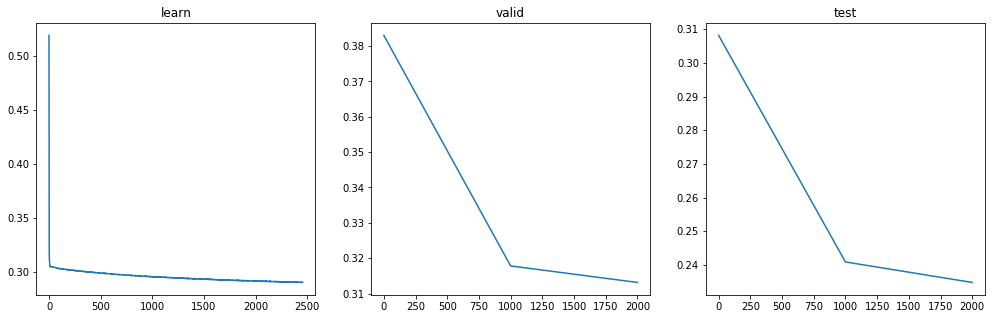

In [16]:
plt.figure(figsize=(17,5))
plt.subplot(1, 3, 1)
plt.plot(learn_epoch_loss)
plt.title('learn')

plt.subplot(1, 3, 2)
plt.plot(epoch_list, valid_epoch_loss)
plt.title('valid')


plt.subplot(1, 3, 3)
plt.plot(epoch_list, test_epoch_loss)
plt.title('test')


plt.savefig('rprop/losss.png', bbox_inches='tight')

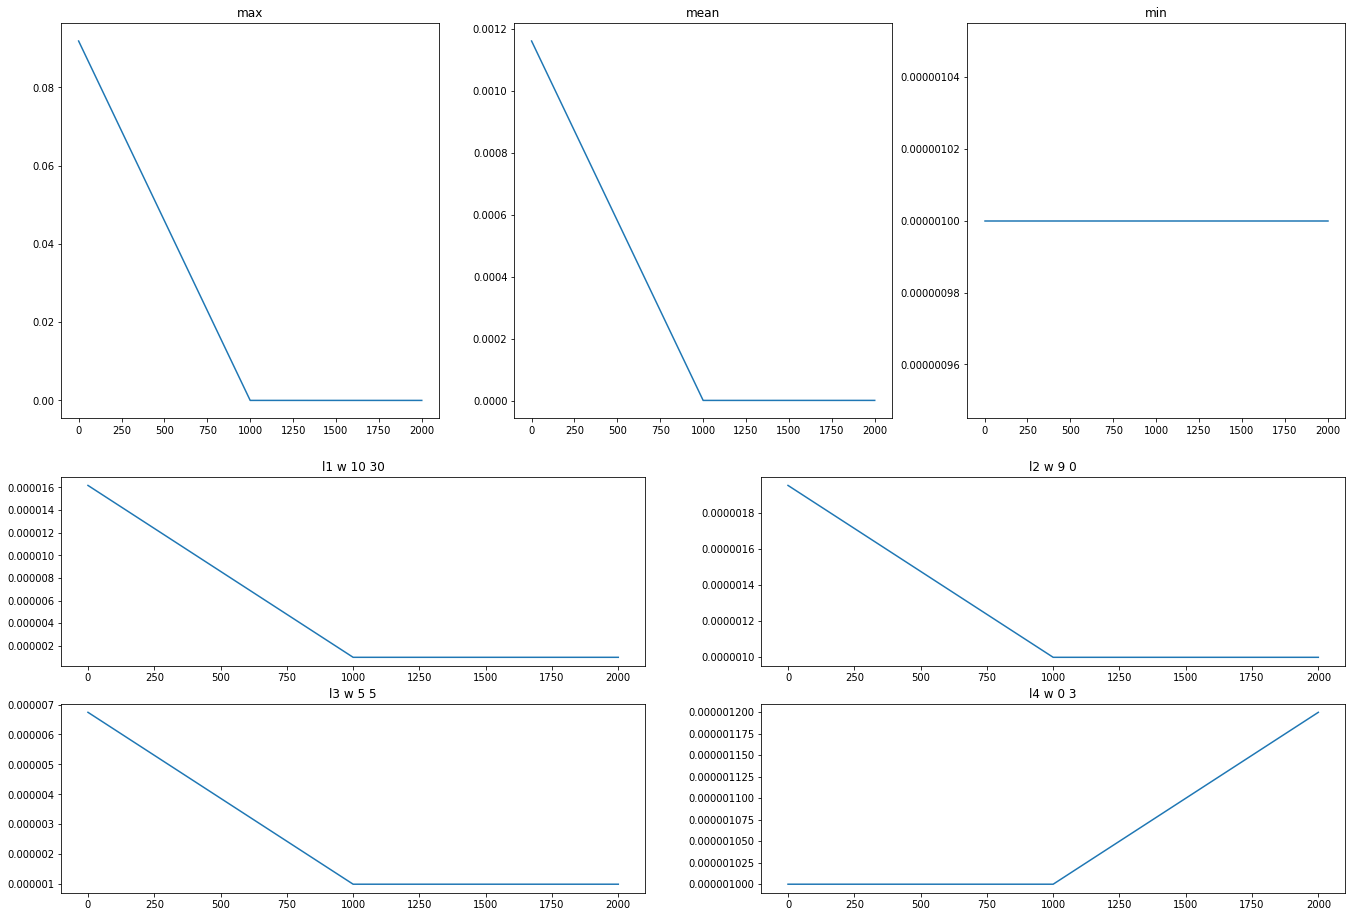

In [17]:
plt.figure(figsize=(23,16))
plt.subplot(4, 2, 5)
plt.plot(epoch_list, delta_l1)
plt.title('l1 w 10 30')

plt.subplot(4, 2, 6)
plt.plot(epoch_list, delta_l2)
plt.title('l2 w 9 0')

plt.subplot(4, 2, 7)
plt.plot(epoch_list, delta_l3)
plt.title('l3 w 5 5')

plt.subplot(4, 2, 8)
plt.plot(epoch_list, delta_l4)
plt.title('l4 w 0 3')

plt.subplot(2, 3, 1)
plt.plot(epoch_list, delta_max)
plt.title('max')

plt.subplot(2, 3, 2)
plt.plot(epoch_list, delta_mean)
plt.title('mean')

plt.subplot(2, 3, 3)
plt.plot(epoch_list, delta_min)
plt.title('min')

plt.savefig('rprop/lrs.png', bbox_inches='tight')

In [18]:
learn_dataloader = DataLoader(learn_dataset, batch_size=len(learn_dataset), shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [19]:
accuracy_by_threshold = collections.defaultdict(list)

for p_threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for learn_data in learn_dataloader:
        features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
        outputs = net(features)
        loss = criterion(outputs, labels)
        predict = outputs > p_threshold
        print('accuracy: ', accuracy_score(labels.detach().numpy(), predict))
        print(float(loss.data))
        accuracy_by_threshold[('learn', p_threshold)] += [accuracy_score(labels.detach().numpy(), predict)]
        
    for test_data in test_dataloader:
        features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
        outputs = net(features)
        loss = criterion(outputs, labels)
        predict = outputs > p_threshold
        print('accuracy: ', accuracy_score(labels.detach().numpy(), predict))
        print(float(loss.data))
        accuracy_by_threshold[('test', p_threshold)] += [accuracy_score(labels.detach().numpy(), predict)]

C:\Users\ASUS\anaconda3\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\ASUS\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\ASUS\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([2398])) that is different to the input size (torch.Size([2398, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


accuracy:  0.7568807339449541
0.2902761995792389
accuracy:  0.75
0.2330968976020813
accuracy:  0.8427856547122602
0.2902762293815613
accuracy:  0.86
0.2330968976020813
accuracy:  0.872393661384487
0.2902762293815613
accuracy:  0.895
0.2330968976020813
accuracy: 

C:\Users\ASUS\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


 0.8869891576313594
0.2902761697769165
accuracy:  0.8975
0.2330968976020813
accuracy:  0.8874061718098415
0.2902761995792389
accuracy:  0.905
0.2330968976020813
accuracy:  0.8832360300250208
0.2902761697769165
accuracy:  0.9025
0.2330968976020813
accuracy:  0.8744787322768974
0.29027625918388367
accuracy:  0.8925
0.2330968976020813
accuracy:  0.8544620517097581
0.2902761995792389
accuracy:  0.8775
0.2330968976020813
accuracy:  0.7977481234361968
0.2902761995792389
accuracy:  0.8275
0.2330968976020813


No handles with labels found to put in legend.


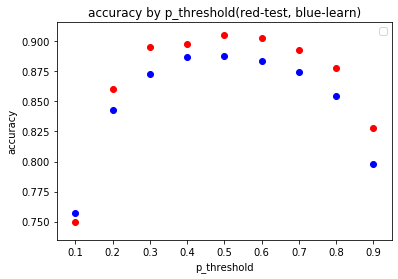

In [20]:
for p_threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.scatter(p_threshold, accuracy_by_threshold[('learn', p_threshold)], c='b')
    plt.scatter(p_threshold, accuracy_by_threshold[('test', p_threshold)], c='r')
plt.legend()
plt.title("accuracy by p_threshold(red-test, blue-learn)")
plt.xlabel('p_threshold')
plt.ylabel('accuracy')
plt.savefig('accuracy by p_threshold.png', bbox_inches='tight')

In [21]:
accuracy_by_threshold

defaultdict(list,
            {('learn', 0.1): [0.7568807339449541],
             ('test', 0.1): [0.75],
             ('learn', 0.2): [0.8427856547122602],
             ('test', 0.2): [0.86],
             ('learn', 0.3): [0.872393661384487],
             ('test', 0.3): [0.895],
             ('learn', 0.4): [0.8869891576313594],
             ('test', 0.4): [0.8975],
             ('learn', 0.5): [0.8874061718098415],
             ('test', 0.5): [0.905],
             ('learn', 0.6): [0.8832360300250208],
             ('test', 0.6): [0.9025],
             ('learn', 0.7): [0.8744787322768974],
             ('test', 0.7): [0.8925],
             ('learn', 0.8): [0.8544620517097581],
             ('test', 0.8): [0.8775],
             ('learn', 0.9): [0.7977481234361968],
             ('test', 0.9): [0.8275]})

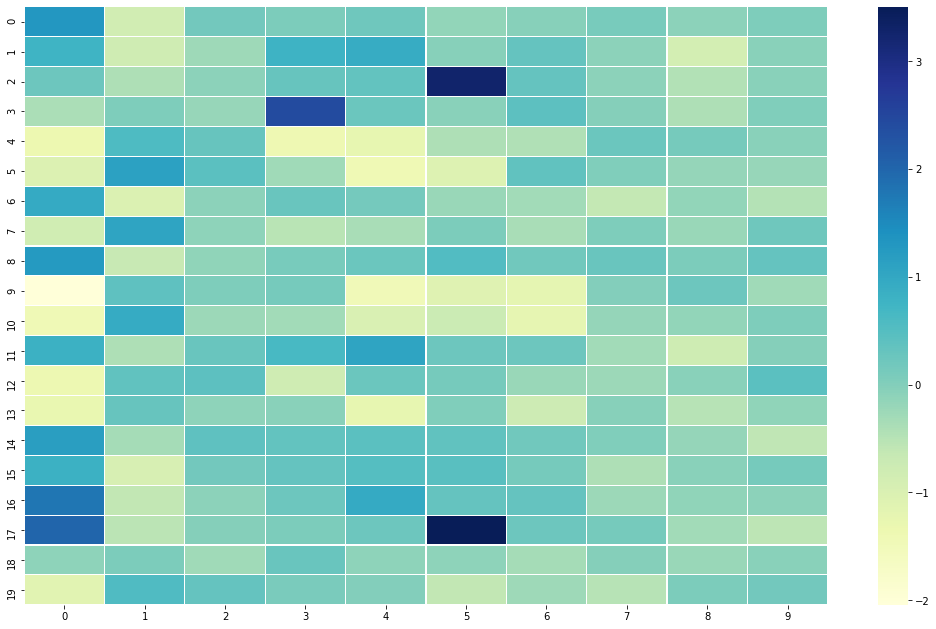

In [22]:
feature_impact = net.lin1.weight.data.numpy()
plt.figure(figsize=(18,11))
sns.heatmap(feature_impact, linewidths=0.1, cmap="YlGnBu")
plt.savefig('feature_impact_heat.png', bbox_inches='tight')

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[1365  116]
 [ 154  763]]
Confusion matrix, without normalization
[[227  20]
 [ 18 135]]


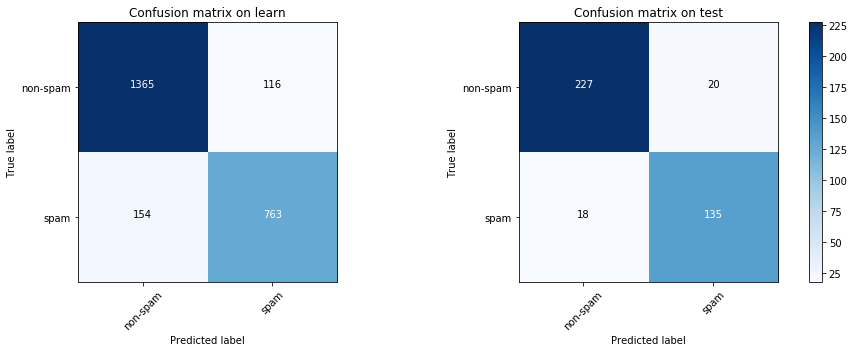

In [24]:
plt.figure(figsize=(15,5))
for learn_data in learn_dataloader:
    features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
    outputs = net(features)
    loss = criterion(outputs, labels)
    predict = outputs > 0.5
    cnf_matrix = confusion_matrix(labels.detach().numpy(), predict.detach().numpy())
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cnf_matrix, classes=['non-spam', 'spam'], title='Confusion matrix on learn')
    
for test_data in test_dataloader:
    features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
    outputs = net(features)
    loss = criterion(outputs, labels)
    predict = outputs > 0.5
    cnf_matrix = confusion_matrix(labels.detach().numpy(), predict.detach().numpy())
    plt.subplot(1, 2, 2)
    plot_confusion_matrix(cnf_matrix, classes=['non-spam', 'spam'], title='Confusion matrix on test')
plt.savefig('matrix_without_norm05.png', bbox_inches='tight')

Normalized confusion matrix
[[0.96623903 0.03376097]
 [0.32606325 0.67393675]]
Normalized confusion matrix
[[0.9757085  0.0242915 ]
 [0.28104575 0.71895425]]


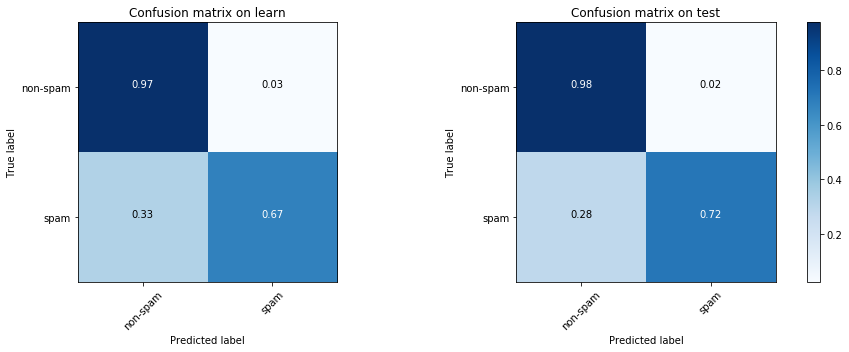

In [25]:
plt.figure(figsize=(15,5))
for learn_data in learn_dataloader:
    features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
    outputs = net(features)
    loss = criterion(outputs, labels)
    predict = outputs > 0.8
    cnf_matrix = confusion_matrix(labels.detach().numpy(), predict.detach().numpy())
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cnf_matrix, classes=['non-spam', 'spam'], title='Confusion matrix on learn', normalize=True)
    
for test_data in test_dataloader:
    features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
    outputs = net(features)
    loss = criterion(outputs, labels)
    predict = outputs > 0.8
    cnf_matrix = confusion_matrix(labels.detach().numpy(), predict.detach().numpy())
    plt.subplot(1, 2, 2)
    plot_confusion_matrix(cnf_matrix, classes=['non-spam', 'spam'], title='Confusion matrix on test', normalize=True)
plt.savefig('matrix_norm08.png', bbox_inches='tight')